In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow/Keras (Keras layers below)
from tensorflow.keras.utils import set_random_seed, to_categorical
set_random_seed(1234) # set the seeds for Python, NumPy, and TensorFlow in order to reproduce the results

# Custom
import sys
sys.path.insert(0, '/home/lcastellazzi/MDM32/src/utils')
from preprocessing import TraceHandler
from nicv import nicv
import constants
from postprocessing import SingleByteEvaluator


# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
paths = {'train': '/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs', # D1_K1
         'test' : '/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs'} # D1_K2

trace_handlers = {key: TraceHandler(path) for key, path in paths.items()}

Labeling traces: 100%|██████████| 50000/50000 [00:21<00:00, 2280.92it/s]


In [3]:
BYTE_IDX = 0
VAL_PERC = 0.1
N_CLASSES = 256

x_train, x_val, y_train, y_val = trace_handlers['train'].generate_train_val(BYTE_IDX, val_perc=VAL_PERC) 
x_test, y_test = trace_handlers['test'].generate_test(BYTE_IDX) 

y_train_cat = to_categorical(y_train, N_CLASSES)
y_val_cat = to_categorical(y_val, N_CLASSES)
y_test_cat = to_categorical(y_test, N_CLASSES)

In [11]:
from tensorflow.keras.optimizers import Adam, RMSprop

hp = {'input_size':         len(x_train[0]), # 1237
      'batch_norm':         [True, False],
      'kernel_initializer': ['random_normal', 'he_normal'],
      'num_hidden_layers':  [1, 2, 3, 4, 5],
      'num_hidden_neurons': [100, 200, 300, 400, 500],
      'dropout':            [True, False],
      'dropout_rate':       [0.0, 0.2, 0.4],
      'batch_size':         256,
      'lr':                 [1e-3, 1e-4, 1e-5],
      'opt':                [Adam, RMSprop]}

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

import random

LOSS = 'categorical_crossentropy'

def build_model(hp):

    chosen_hp = {'BATCH_NORM': random.choice(hp['batch_norm']),
                 'KERNEL_INITIALIZER': random.choice(hp['kernel_initializer']),
                 'NUM_HIDDEN_LAYERS': random.choice(hp['num_hidden_layers']),
                 'NUM_HIDDEN_NEURONS': random.choice(hp['num_hidden_neurons']),
                 'DROPOUT': random.choice(hp['dropout']),
                 'DROPOUT_RATE': random.choice(hp['dropout_rate']),
                 'LR': random.choice(hp['lr']), 
                 'OPT': random.choice(hp['opt'])}
    
    ############################################################
    # Init model
    model = Sequential()

    # Input
    model.add(Dense(hp['input_size'], 
                    kernel_initializer=chosen_hp['KERNEL_INITIALIZER'], 
                    activation='relu'))

    # Batch Normalization
    if chosen_hp['BATCH_NORM']:
        model.add(BatchNormalization())

    # Hidden
    for _ in range(chosen_hp['NUM_HIDDEN_LAYERS']):
        model.add(Dense(chosen_hp['NUM_HIDDEN_NEURONS'], 
                        kernel_initializer=chosen_hp['KERNEL_INITIALIZER'],
                        activation='relu'))

        # Dropout
        if chosen_hp['DROPOUT']:
            model.add(Dropout(chosen_hp['DROPOUT_RATE']))

    # Batch Normalization
    if chosen_hp['BATCH_NORM']:
        model.add(BatchNormalization())

    # Output
    model.add(Dense(N_CLASSES, activation='softmax'))
    ############################################################

    model.compile(optimizer=chosen_hp['OPT'](learning_rate=chosen_hp['LR']),
                  loss=LOSS,
                  metrics=['accuracy'])
                                        
    return model, chosen_hp

In [14]:
N_MODELS = 10

models = [build_model(hp) for _ in range(N_MODELS)]

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=5)

In [16]:
NUM_EPOCHS = 100

histories = []
for i, model in enumerate(models):
    model = model[0]
    
    print(f'------------------------------ MODEL {i+1}/{N_MODELS} ------------------------------')
    
    history = model.fit(x_train, 
                        y_train_cat,
                        validation_data=(x_val, y_val_cat),
                        epochs=NUM_EPOCHS,
                        batch_size=hp['batch_size'],
                        callbacks=[es],
                        verbose=1)
    histories.append(history)
    
    print()

------------------------------ MODEL 1/10 ------------------------------
Epoch 1/100
176/176 [==============================] - 1s 3ms/step - loss: 22.8589 - accuracy: 0.0038 - val_loss: 5.6024 - val_accuracy: 0.0032
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 5.5879 - accuracy: 0.0041 - val_loss: 5.5606 - val_accuracy: 0.0034
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 5.5580 - accuracy: 0.0039 - val_loss: 5.5528 - val_accuracy: 0.0040
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 5.5513 - accuracy: 0.0045 - val_loss: 5.5500 - val_accuracy: 0.0038
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 5.5480 - accuracy: 0.0048 - val_loss: 5.5483 - val_accuracy: 0.0038
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 5.5468 - accuracy: 0.0046 - val_loss: 5.5478 - val_accuracy: 0.0038
Epoch 7/100
176/176 [==============================] - 0s 2ms/step -

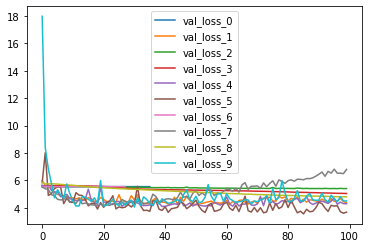

In [17]:
for i, history in enumerate(histories):
    # plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label=f'val_loss_{i}')
plt.legend()
plt.show()

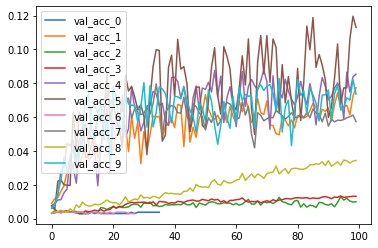

In [18]:
for i, history in enumerate(histories):
    # plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label=f'val_acc_{i}')
plt.legend()
plt.show()

# -----------------------------------------------------------------

In [19]:
test_plaintexts = trace_handlers['test'].get_plaintexts()
true_key_byte = trace_handlers['test'].get_key()[BYTE_IDX]

total_tmps = []
for i, model in enumerate(models):
    model = model[0]
    tmp = []
    for i in tqdm(range(100), desc=f'Model {i+1}/{N_MODELS}: '):
        label_preds = model.predict(x_test[:i+1])

        evaluator = SingleByteEvaluator(test_plaintexts=test_plaintexts[:i+1],
                                        byte_idx=BYTE_IDX,
                                        label_preds=label_preds)

        tmp.append(evaluator.rank(true_key_byte))
    total_tmps.append(np.array(tmp))
    
total_tmps = np.array(total_tmps)

Model 10/10: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


100%|██████████| 10/10 [00:00<00:00, 3047.08it/s]


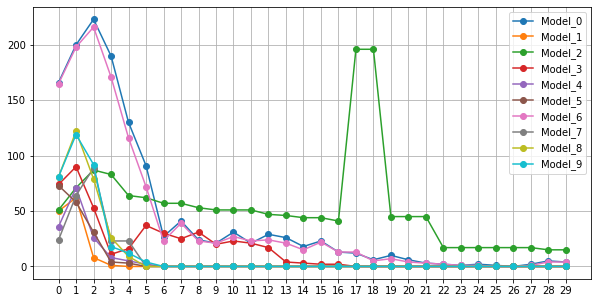

In [31]:
MAX_TRACES_TO_PLOT = 30

plt.figure(figsize=(10, 5))
plt.xticks(range(MAX_TRACES_TO_PLOT))
# plt.axhline(y=0, color='black', linestyle=':')
for i, tmp in enumerate(tqdm(total_tmps)):
    plt.plot(tmp[:MAX_TRACES_TO_PLOT], marker='o', label=f'Model_{i}')
plt.legend()
plt.grid()
plt.show()

In [21]:
evaluator.get_predicted_key_byte()

'5d'

In [32]:
curr_model, curr_hp = models[1]
preds = curr_model.predict(x_test[:100])
ev = SingleByteEvaluator(test_plaintexts=test_plaintexts[:100],
                         byte_idx=BYTE_IDX,
                         label_preds=preds)
ev.rank(true_key_byte)
ev.get_predicted_key_byte()

'5d'

In [33]:
curr_hp

{'BATCH_NORM': True,
 'KERNEL_INITIALIZER': 'he_normal',
 'NUM_HIDDEN_LAYERS': 2,
 'NUM_HIDDEN_NEURONS': 100,
 'DROPOUT': True,
 'DROPOUT_RATE': 0.0,
 'LR': 0.0001,
 'OPT': keras.optimizer_v2.rmsprop.RMSprop}

In [ ]:
# Try to get the model with min num of traces to get 0 and plot its parameters